<a href="https://colab.research.google.com/github/Shobhit2000/Automatic_colourization-Autoencoders-/blob/master/Automatic_Colourization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTING LIBRARIES**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

from keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend as K

In [0]:
def rgb_gray(img):
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return gray_img

**LOAD DATA**

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [0]:
print(x_train.shape)
print(x_test.shape)
img_dim = x_train.shape[1]
channels = 3

(50000, 32, 32, 3)
(10000, 32, 32, 3)


CONVERT RGB TRAINING IMAGES TO GRAYSCALE IMAGES

In [0]:
x_train_Gray = []
x_test_Gray = []


for i in range(x_train.shape[0]):
  img = x_train[i]
  x_train_Gray.append(rgb_gray(img))

for i in range(x_test.shape[0]):
  img = x_test[i]
  x_test_Gray.append(rgb_gray(img))


In [0]:
print(len(x_train_Gray))
print(len(x_test_Gray))

50000
10000


In [0]:
x_train_Gray = np.asarray(x_train_Gray)
x_test_Gray = np.asarray(x_test_Gray)

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train_Gray = x_train_Gray.astype('float32')/255
x_test_Gray = x_test_Gray.astype('float32')/255


In [0]:
x_train = x_train.reshape(x_train.shape[0], img_dim, img_dim, channels)
x_test = x_test.reshape(x_test.shape[0], img_dim, img_dim, channels)
x_train_Gray = x_train_Gray.reshape(x_train_Gray.shape[0], img_dim, img_dim, 1)
x_test_Gray = x_test_Gray.reshape(x_test_Gray.shape[0], img_dim, img_dim, 1)

In [0]:
input_shape = (img_dim, img_dim, 1)
lat_dim = 256

**ENCODER MODEL**

In [0]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)

In [0]:
shape = K.int_shape(x)

In [0]:
x = Flatten()(x)
latent = Dense(lat_dim, name='latent_vector')(x)

In [0]:
encoder = Model(inputs, latent, name='encoder_model')

In [0]:
encoder.summary()

Model: "encoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
___________________________________________

**DECODER MODEL**

In [0]:
latent_inputs = Input(shape = (lat_dim,), name = 'decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [0]:
x = Conv2DTranspose(256, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(128, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(64, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)

In [0]:
outputs = Conv2DTranspose(3, (3,3), activation = 'sigmoid', padding = 'same', name = 'decoder_output')(x)

In [0]:
decoder = Model(latent_inputs, outputs, name = 'decoder_model')

In [0]:
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              1052672   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)       

**AUTOENCODER MODEL**

In [0]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name = 'autoencoder')

In [0]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
encoder_model (Model)        (None, 256)               1418496   
_________________________________________________________________
decoder_model (Model)        (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


In [0]:
lr_reducer = ReduceLROnPlateau(factor = np.sqrt(0.1), cooldown = 0, patience = 5, verbose = 1, min_lr = 0.5e-6)

In [0]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [0]:
print(filepath)

/content/saved_models/colorized_ae_model.h5


In [0]:
checkpoints = ModelCheckpoint(filepath = filepath, 
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True)

In [0]:
callbacks = [lr_reducer, checkpoints]

**TRAINING**

In [0]:
autoencoder.compile(loss = 'mse', optimizer = 'Adam', metrics = ['accuracy'])

In [0]:
autoencoder.fit(x_train_Gray, x_train, validation_data = (x_test_Gray, x_test),epochs = 30, batch_size = 32, callbacks = callbacks)




Train on 50000 samples, validate on 10000 samples
Epoch 1/30





50000/50000 [==============================] - 48s 957us/step - loss: 0.0150 - acc: 0.4832 - val_loss: 0.0105 - val_acc: 0.4790

Epoch 00001: val_loss improved from inf to 0.01050, saving model to /content/saved_models/colorized_ae_model.h5
Epoch 2/30
50000/50000 [==============================] - 45s 909us/step - loss: 0.0098 - acc: 0.5061 - val_loss: 0.0092 - val_acc: 0.4940

Epoch 00002: val_loss improved from 0.01050 to 0.00924, saving model to /content/saved_models/colorized_ae_model.h5
Epoch 3/30
50000/50000 [==============================] - 45s 905us/step - loss: 0.0088 - acc: 0.5132 - val_loss: 0.0085 - val_acc: 0.5164

Epoch 00003: val_loss improved from 0.00924 to 0.00851, saving model to /content/saved_models/colorized_ae_model.h5
Epoch 4/30
50000/50000 [==============================] - 45s 909us/step - loss: 0.0083 - acc: 0.5191 - val_loss: 0.0081 - val_acc: 0.5157

Epoch 00004: val_loss improved from 0.

In [0]:
x_decoded = autoencoder.predict(x_test_Gray)

In [0]:
autoencoder.save('colourization_model.h5')

In [0]:
from google.colab import files
files.download('colourization_model.h5')

**Displaying Results**

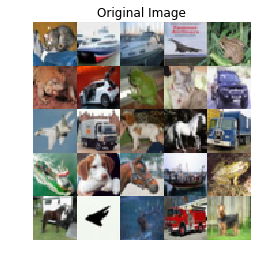

In [0]:
imgs = x_test[:25]
imgs = imgs.reshape((5, 5, img_dim, img_dim, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Original Image')
plt.imshow(imgs, interpolation='none')
#plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()

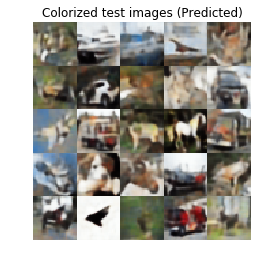

In [0]:
imgs = x_decoded[:25]
imgs = imgs.reshape((5, 5, img_dim, img_dim, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
#plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()